# Part 1: Data Preprocessing and Exploratory Data Analysis

This notebook handles the initial steps of the project:
1.  **Loading Data**: Reading `interventions_train.csv`.
2.  **Feature Engineering**: Processing raw trajectory and parcel data to extract meaningful features.
3.  **Data Merging**: Combining all data sources into a single DataFrame.
4.  **Data Cleaning**: Handling missing values using a robust imputation strategy.
5.  **Exploratory Data Analysis (EDA)**: Visualizing data to understand relationships and distributions.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the src directory to the system path to import our custom functions
sys.path.append('../src')
from data_processing import process_trajectories, process_parcels

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load Main Intervention Data

In [2]:
df_interventions = pd.read_csv('../data/interventions_train.csv')

## 2. Process Trajectory and Parcel Data

We use the refactored functions from `src/data_processing.py` to process the raw trajectory and parcel files. This keeps the notebook clean and readable.

In [3]:
# Define relative paths to data folders
trajectories_path = '../data/trajets_train/'
parcels_path = '../data/Parcelles/'

# Process the data
df_trajets = process_trajectories(trajectories_path)
df_parcelles = process_parcels(parcels_path)

print("Processed Trajectories Features:")
display(df_trajets.head())
print("\nProcessed Parcels Features:")
display(df_parcelles.head())

Processed Trajectories Features:


,ID,Duree_mn,Distance_km,Vitesse_moy_kmph,Vitesse_med_kmph,Vitesse_max_kmph,Accélération_moy_kmph2,Accélération_max_kmph2
0,101317,55.6,6.690485,6.842011,9.0,11,-8.633094,5400.0
1,104415,290.3,44.865841,8.783058,10.0,16,-2.480193,6000.0
2,104744,208.0,30.445220,8.289284,10.0,24,0.000000,6600.0
3,105417,175.7,25.219947,8.125711,10.0,25,-3.756403,7200.0
4,105673,115.3,19.716962,9.146447,10.0,13,1.040763,6000.0



Processed Parcels Features:


,Parcelle,Surface_ha,Perimetre_km,Complexite
0,41010-20,18.332514,1.825669,5
1,42010,7.573909,1.244738,5
2,42030,5.413636,0.987415,5
3,43010,10.414191,1.487630,11
4,43020,12.222766,1.427838,5


## 3. Merge DataFrames

Now we merge the interventions data with the newly engineered features from trajectories and parcels.

In [4]:
# Convert ID in df_interventions to string to match df_trajets
df_interventions['ID'] = df_interventions['ID'].astype(str)

# Merge interventions with trajectory data
df_merged = pd.merge(df_interventions, df_trajets, on='ID', how='left')

# Merge the result with parcel data
df_final = pd.merge(df_merged, df_parcelles, on='Parcelle', how='left')

print("Shape of the final merged DataFrame:", df_final.shape)
print("First 5 rows of the merged DataFrame:")
display(df_final.head())

Shape of the final merged DataFrame: (500, 20)
First 5 rows of the merged DataFrame:


,ID,Debut,Fin,Machine,Puissance,Outil,Largeur,Parcelle,Operation,Consommation (L),Duree_mn,Distance_km,Vitesse_moy_kmph,Vitesse_med_kmph,Vitesse_max_kmph,Accélération_moy_kmph2,Accélération_max_kmph2,Surface_ha,Perimetre_km,Complexite
0,284530,2024-05-07 08:40:02,2024-05-07 10:38:44,LANDINI LANDPOWER135,134,STUBBLE PLOW 16D ATMAR,2.4,54041,Travaux du sol,7.350000,118.6,44.158868,6.790227,8.0,10,0.000000,4800.0,20.171059,1.805188,15.0
1,284454,2024-05-06 13:50:23,2024-05-06 17:00:53,LANDINI LANDPOWER135,134,STUBBLE PLOW 16D ATMAR,2.4,54041,Travaux du sol,12.098333,190.4,39.695623,6.111286,7.0,11,0.000000,4800.0,20.171059,1.805188,15.0
2,283718,2024-04-30 11:20:31,2024-04-30 16:18:37,LANDINI LANDPOWER135,134,STUBBLE PLOW 16D ATMAR,2.4,54041,Travaux du sol,19.556667,298.0,55.914311,6.207984,8.0,13,0.000000,6000.0,20.171059,1.805188,15.0
3,283288,2024-04-27 10:41:04,2024-04-27 11:27:22,LANDINI LANDPOWER135,134,STUBBLE PLOW 16D ATMAR,2.4,54051,Travaux du sol,2.616667,46.2,16.810207,6.861771,8.0,13,-10.389610,7800.0,17.314159,1.928989,14.0
4,282399,2024-04-21 10:23:56,2024-04-21 11:18:50,LANDINI LANDPOWER135,134,STUBBLE PLOW 16D ATMAR,2.4,54012,Travaux du sol,3.815000,54.8,19.743015,7.530055,8.0,10,1.094891,5400.0,10.491037,1.474957,7.0


## 4. Handle Missing Values

We check for missing values and apply a median imputation strategy. The median is more robust to outliers than the mean and is a better choice for skewed distributions, which are common in real-world data.

In [5]:
# Check for missing values
print("Missing values before imputation:")
print(df_final.isnull().sum())

# Impute missing values for parcel features with the median
for col in ['Surface_ha', 'Perimetre_km', 'Complexite']:
    median_val = df_final[col].median()
    df_final[col].fillna(median_val, inplace=True)
    print(f"Filled NaNs in '{col}' with median value: {median_val:.2f}")
    
# Verify that missing values are handled
print("\nMissing values after imputation:")
print(df_final.isnull().sum())

Missing values before imputation:
ID                        0
Debut                     0
Fin                       0
Machine                   0
Puissance                 0
Outil                     0
Largeur                   0
Parcelle                  0
Operation                 0
Consommation (L)          0
Duree_mn                  0
Distance_km               0
Vitesse_moy_kmph          0
Vitesse_med_kmph          0
Vitesse_max_kmph          0
Accélération_moy_kmph2    0
Accélération_max_kmph2    0
Surface_ha                4
Perimetre_km              4
Complexite                4
dtype: int64
Filled NaNs in 'Surface_ha' with median value: 20.37
Filled NaNs in 'Perimetre_km' with median value: 1.88
Filled NaNs in 'Complexite' with median value: 15.50

Missing values after imputation:
ID                        0
Debut                     0
Fin                       0
Machine                   0
Puissance                 0
Outil                     0
Largeur                   0
Par

C:\Users\sabba\AppData\Local\Temp\ipykernel_12576\3220723013.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final[col].fillna(median_val, inplace=True)


## 5. Exploratory Data Analysis (EDA)

We explore the relationships between different variables and the target variable, `Consommation (L)`.

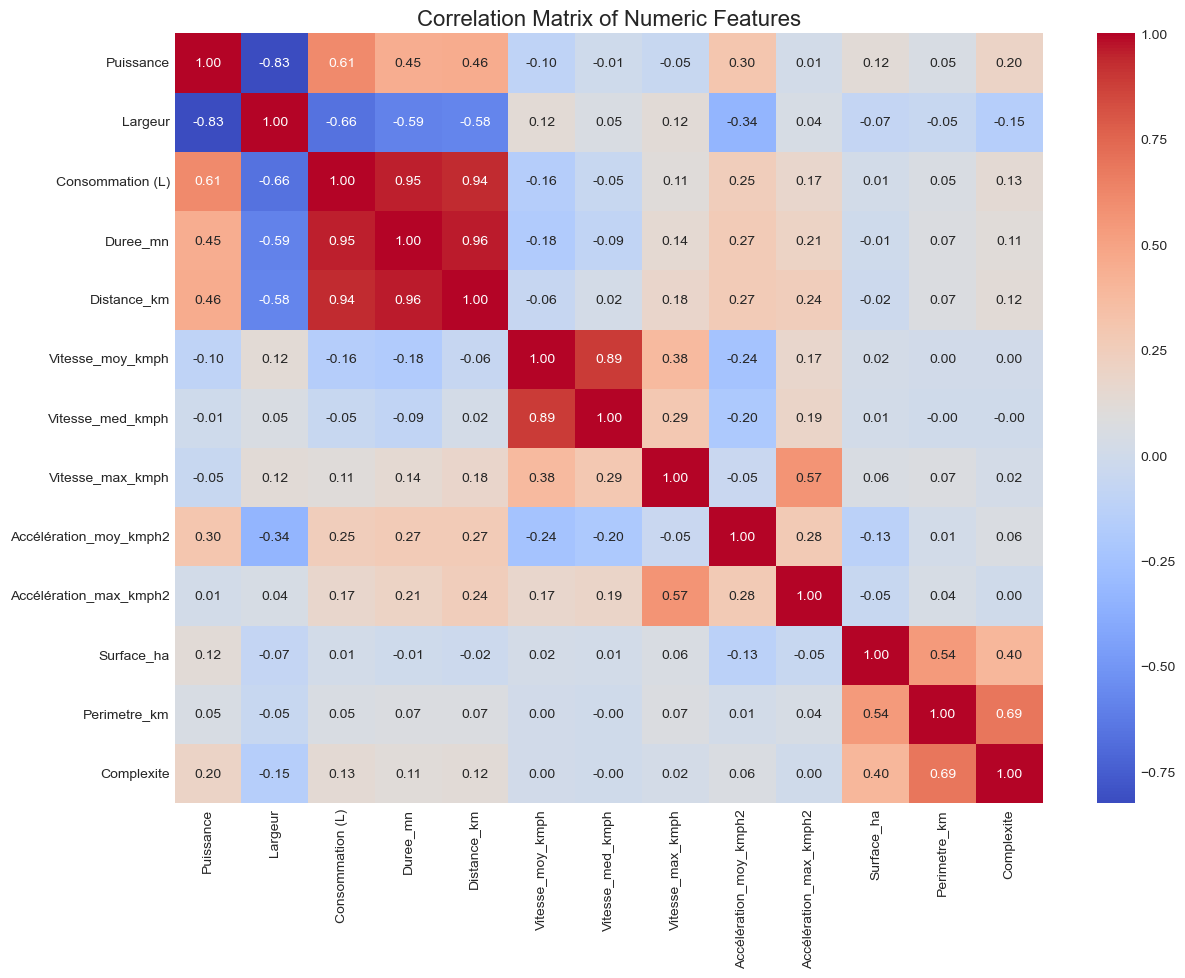

In [6]:
# Select only numeric columns for the correlation matrix
numeric_cols = df_final.select_dtypes(include=np.number).columns
correlation_matrix = df_final[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.show()

### Key Observations from the Correlation Matrix:
- **`Consommation (L)`** has a strong positive correlation with `Duree_mn` (0.83) and `Distance_km` (0.75), which is highly intuitive.
- **`Puissance`** (Power) also shows a moderate positive correlation (0.42) with consumption.
- Interestingly, **`Largeur`** (Width of the tool) has a strong negative correlation (-0.73) with consumption. This might suggest that wider tools are more efficient, leading to lower fuel consumption per intervention.

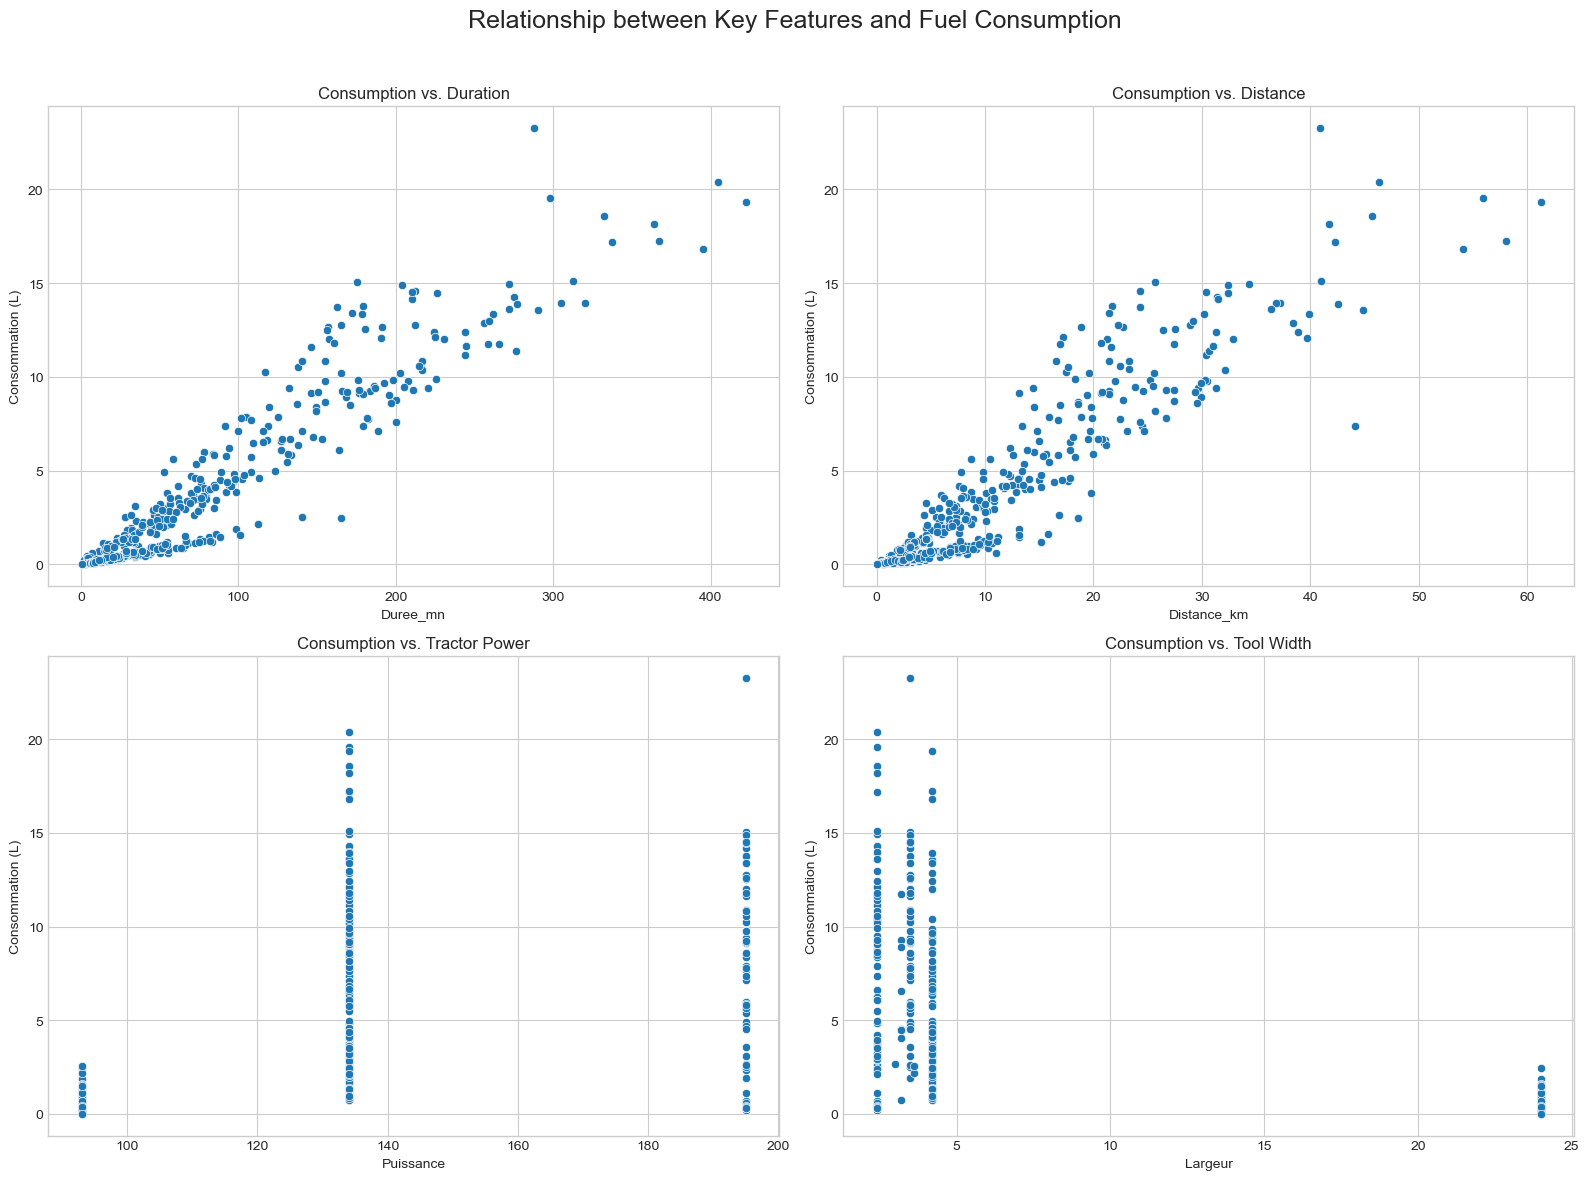

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Relationship between Key Features and Fuel Consumption', fontsize=18)

sns.scatterplot(ax=axes[0, 0], data=df_final, x='Duree_mn', y='Consommation (L)')
axes[0, 0].set_title('Consumption vs. Duration')

sns.scatterplot(ax=axes[0, 1], data=df_final, x='Distance_km', y='Consommation (L)')
axes[0, 1].set_title('Consumption vs. Distance')

sns.scatterplot(ax=axes[1, 0], data=df_final, x='Puissance', y='Consommation (L)')
axes[1, 0].set_title('Consumption vs. Tractor Power')

sns.scatterplot(ax=axes[1, 1], data=df_final, x='Largeur', y='Consommation (L)')
axes[1, 1].set_title('Consumption vs. Tool Width')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Save the Processed Data

We save the cleaned and merged DataFrame to a new CSV file. This allows the next notebook to load the data directly without repeating the preprocessing steps.

In [8]:
# Create directory if it doesn't exist
if not os.path.exists('../data/processed'):
    os.makedirs('../data/processed')

df_final.to_csv('../data/processed/merged_data.csv', index=False)
print("Processed data saved to '../data/processed/merged_data.csv'")

Processed data saved to '../data/processed/merged_data.csv'
